# 1. 展示梯度

In [133]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
def f(x):
  return 3*x**2 - 4*x + 5

In [135]:
f(3.0)

20.0

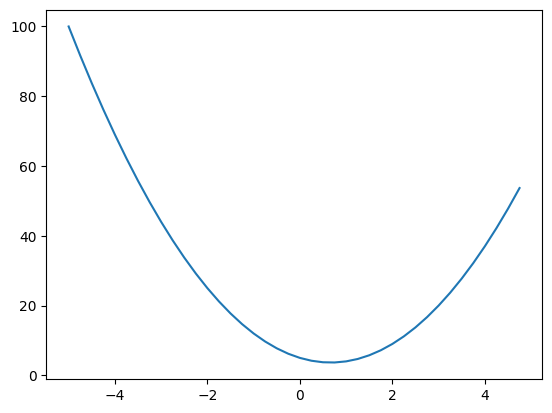

In [136]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [137]:
# 一元情况计算斜率
# 由上图和解析式计算可知, f(x)在x=2/3处梯度为0
h = 0.00001
x = 2/3
(f(x + h) - f(x)) / h

3.0000002482211127e-05

In [138]:
# 多元的情况
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1:%.3f, d2:%.3f, slope:%.3f" % (d1, d2, (d2-d1)/h)) # c's slope

d1 = a*b + c
a += h
d2 = a*b + c

print("d1:%.3f, d2:%.3f, slope:%.3f" % (d1, d2, (d2-d1)/h)) # a's slope

d1 = a*b + c
b += h
d2 = a*b + c

print("d1:%.3f, d2:%.3f, slope:%.3f" % (d1, d2, (d2-d1)/h)) # b's slope

d1:4.000, d2:4.000, slope:1.000
d1:4.000, d2:4.000, slope:-3.000
d1:4.000, d2:4.000, slope:2.000


# 自动梯度

## 1. 自动梯度的计算图结构体
![](./pig/comp_graph-1.png)
![](./pig/comp_graph-2.png)

In [139]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
# 计算图结构体
class Value:
  
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other): # self.__add__(other)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): # 链式法则
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # 2 + a 则调用a.__rmul__(2)
        return self + other

    def __sub__(self, other): # self.__sub__(other)
        return self + (-other)

    def __rsub__(self, other):
        return -self + other

    def __mul__(self, other):  # self.__mul__(other)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # 2 * a 则调用a.__rmul__(2)
        return self * other
        
    def __neg__(self):
        return self * (-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out
        
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return self**-1 * other

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        t = 0 if self.data < 0 else self.data
        out = Value(t, (self,), 'relu')

        def _backward():
            self.grad += (out.data >= 0) * out.grad
        out._backward = _backward

        return out
        
      

    def backward(self): # 反向传播求导
        # 找到计算图中的每个节点，然后从后往前反向传播
        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v) 
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

a = Value(-5)
b = Value(3)
c = a.relu()

c


Value(data=0, grad=0.0)

## 2. 画出计算图

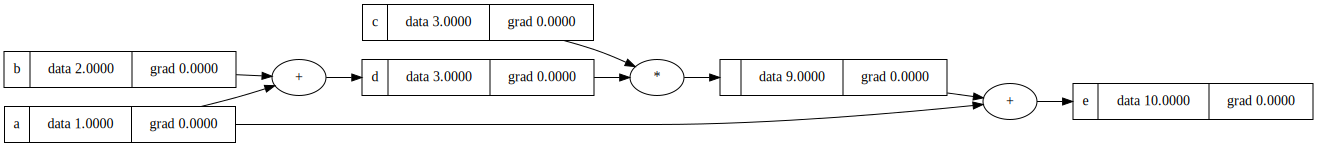

In [141]:
from graphviz import Digraph

# 获取计算图中所有的边和节点
def trace(root):
    nodes, edges = set(), set() # 使用set()更加高效
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: 从左到右画图
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n)) # 唯一的内存地址
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot
    
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(3, label='c')

d = a + b; d.label='d'
e = d * c + a; e.label='e'
draw_dot(e)
            
    
    

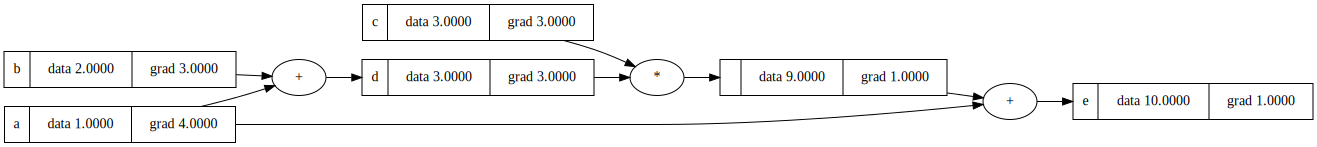

In [142]:
e.backward()
draw_dot(e)

# 神经网络的自动微分

## 1. 神经网络结构体
![](./pig/nn-1.png)

In [143]:
import torch

In [144]:

# 单个神经元: 输入多个特征, 输出一个值
class Neuron:

    def __init__(self, nin): 
        # self.w = []
        # for i in range(nin):
        #     self.w.extend([Value(random.uniform(-1, 1))])
        # 每个参数相当于计算图中的一个节点
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # 简化写法
        self.b = Value(random.uniform(-1, 1))
        
    # def __repr__(self):
    #     return f'params-w: {self.w}\n\tparams-b:{self.b}'

    def __call__(self, x): # 跟函数调用一样调用该类
        # w * x + b
        act = sum(( wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self): # 将参数串联
        return self.w + [self.b]

# 一层神经元: 每个神经元的输入等于上一层的神经元数, 输出等于下一层的神经元数
class Layer:
    
    def __init__(self, nin, nout): 
        self.nout = nout
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # def __repr__(self):
    #     for i in range(self.nout):
    #         print(f'neuron-{i}: {self.neurons[i]}')
    #     return ""
       
    def __call__(self, x): # 每个神经元都输入单个样本的特征
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self): # 遍历一层神经元的每个神经元的参数
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''等同于代码
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        '''

# 多层感知机: 把每一层神经元连接起来即可
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]   

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.6785297433520219, grad=0.0)

In [145]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.7126946357080373, grad=0.0),
 Value(data=0.9992372050589466, grad=0.0),
 Value(data=-0.7968557384615881, grad=0.0)]

In [146]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 神经网络结构为3,4,4,1
n(x)


Value(data=-0.20654524511676334, grad=0.0)

## 2. 神经网络训练

In [147]:

n = MLP(3, [4, 4, 1]) # 神经网络结构为3,4,4,1

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] # 4个输入样本, 每个样本3个特征
ys = [1.0, -1.0, -1.0, 1.0] # 标签值. 每个输入样本一个对应得输出标签值

In [148]:
epoch = 20
for k in range(epoch):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # 均方误差
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)
    

0 1.4807911335165926
1 6.324590095147194
2 2.3865042193406993
3 5.870372078989032
4 0.49886189367956674
5 0.17728255131877785
6 0.1078416457109924
7 0.08083058003729872
8 0.064624894787432
9 0.05370610601838548
10 0.04577800672105868
11 0.0398949844837463
12 0.0352356625705353
13 0.03159154900858077
14 0.02854493940282261
15 0.026030853931407142
16 0.023948878388747943
17 0.02216142100568188
18 0.020590754164861308
19 0.019194765771337483


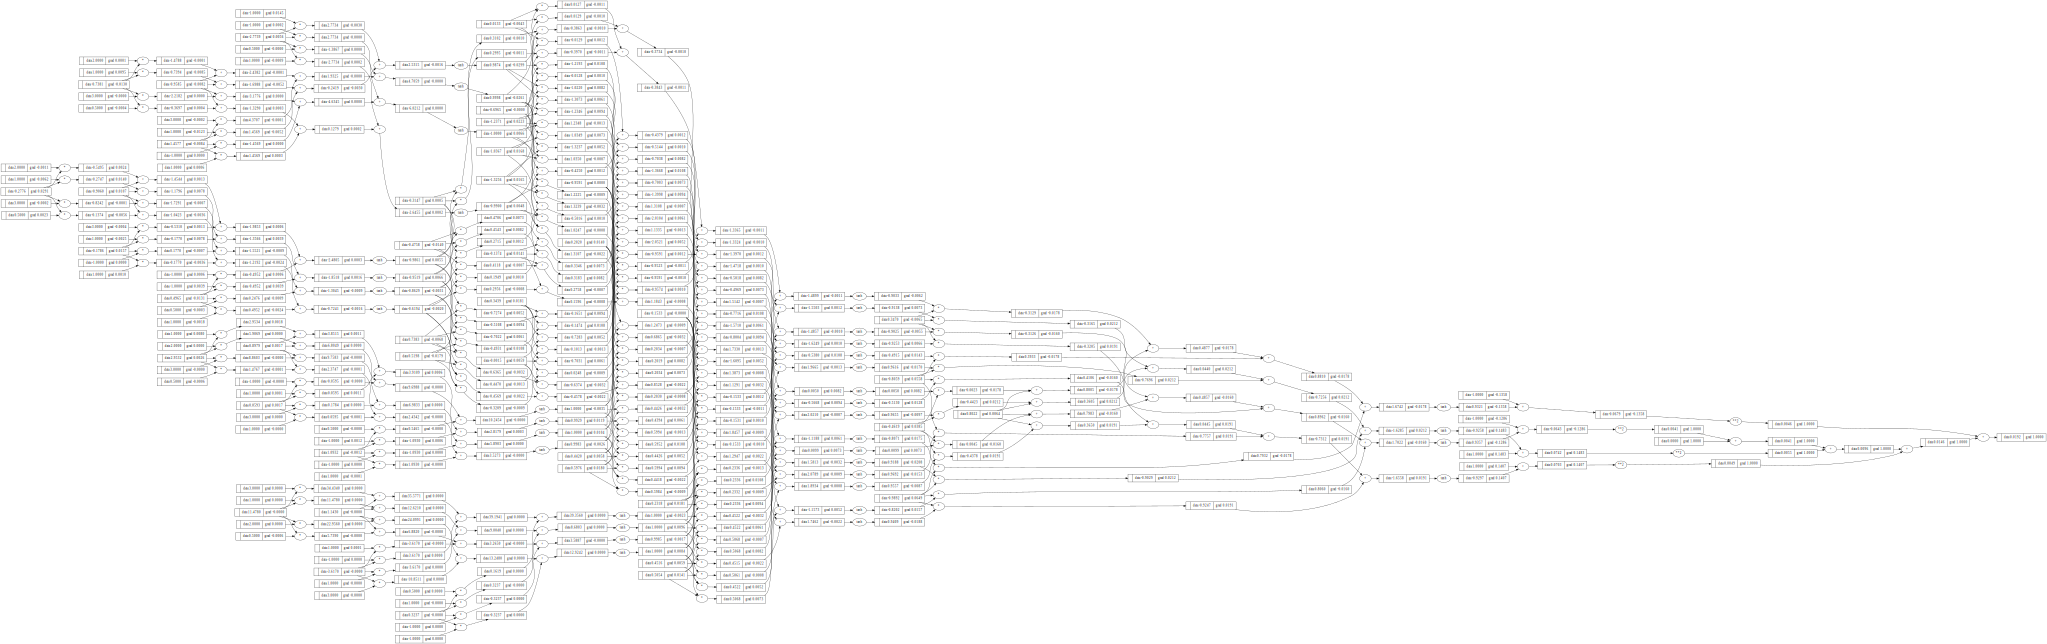

In [149]:
draw_dot(loss)